In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.colors as mcolors

from mechir.data import CatDataCollator, DotDataCollator, MechDataset

In [3]:
FORMATTED_MODEL_NAME = 'crystina-z-monoELECTRA_LCE_nneg31'
MODEL_TYPE = 'cross'
PERTURBATION = 'TFC1'
K = 4000
BATCH_SIZE = 20

data_path = f'./data/patching_unnormalised/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_{K}_batch_size_{BATCH_SIZE}_patch_head.npy'
topk_file = f"./data/topk_my/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv"

patching_results = np.load(data_path)
original_scores = np.load(data_path.replace('patch_head', 'original_scores'))
perturbed_scores = np.load(data_path.replace('patch_head', 'perturbed_scores'))
all_data_pd = pd.read_csv(topk_file, sep='\t')
all_data_pd['injected_term'] = all_data_pd['perturbed_text'].apply(lambda text: text.rsplit(' ', 1)[-1])


unique_terms = all_data_pd['injected_term'].unique()
text_to_id = {text: idx for idx, text in enumerate(unique_terms)}
all_data_pd['term_id'] = all_data_pd['injected_term'].map(text_to_id)

unique_queries = all_data_pd['query'].unique()
query_to_id = {text: idx for idx, text in enumerate(unique_queries)}
all_data_pd['qid_sequential'] = all_data_pd['query'].map(query_to_id)

In [4]:
all_data_pd

,qid,query,docno,text,relevance,perturbed,perturbed_score,rank,original_score,score_delta,perturbed_text,injected_term,term_id,qid_sequential
0,855410,what is theraderm used for,7128710,It is used to trap sunlight for the manufactur...,0,True,5.290899,0,-7.387448,12.678347,It is used to trap sunlight for the manufactur...,theraderm,0,0
1,855410,what is theraderm used for,3276027,"A mental grouping of similar things, events, a...",0,True,2.807054,30,-9.529633,12.336688,"A mental grouping of similar things, events, a...",theraderm,0,0
2,855410,what is theraderm used for,8751749,": to add moisture to (something, such as a per...",0,True,2.844434,26,-9.467996,12.312429,": to add moisture to (something, such as a per...",theraderm,0,0
3,855410,what is theraderm used for,2945339,1 used to form adjectives Resembling or imitat...,0,True,2.434965,38,-9.695806,12.130772,1 used to form adjectives Resembling or imitat...,theraderm,0,0
4,583468,what carvedilol used for,129686,Bottles of eau de toilette. Eau de toilette (F...,0,True,1.873736,226,-10.083253,11.956989,Bottles of eau de toilette. Eau de toilette (F...,carvedilol,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,405163,is caffeine an narcotic,7339772,Combination or cocktail drugs that contain a c...,3,True,-4.797085,258,-4.803654,0.006569,Combination or cocktail drugs that contain a c...,caffeine,79,19
3996,324585,how much money do motivational speakers make,405281,Fee structures for more experienced and profes...,3,True,2.972391,8,2.965918,0.006473,Fee structures for more experienced and profes...,motivational,24,24
3997,1132532,average annual income data analyst,6117745,What Data Analysts Make. Since the field of da...,3,True,2.125537,69,2.119307,0.006230,What Data Analysts Make. Since the field of da...,analyst,122,81
3998,1113256,what is reba mcentire's net worth,7561111,Reba McEntire is a popular American singer wit...,3,True,5.698447,7,5.692532,0.005915,Reba McEntire is a popular American singer wit...,net,137,26


In [5]:
n_colors = len(unique_terms)
colors = plt.cm.nipy_spectral(np.linspace(0, 1, n_colors))
discrete_cmap_injected_terms = mcolors.ListedColormap(colors)

n_colors = len(unique_queries)
colors = plt.cm.nipy_spectral(np.linspace(0, 1, n_colors))
discrete_cmap_queries = mcolors.ListedColormap(colors)

In [6]:
score_difference = perturbed_scores - original_scores

patching_results_normalised = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                np.abs((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis])))
patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                        np.sqrt(1 + (perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis])**2))
patching_results_normalised_vectors = patching_results_normalised.reshape(patching_results_normalised.shape[0], -1)
patching_results_normalised_vectors_square = patching_results_normalised_square.reshape(patching_results_normalised_square.shape[0], -1)
patching_results_normalised_duplicate_heads =  np.mean(np.abs(patching_results_normalised)[:, [0,1,2], [9,6,3]], axis=-1)
patching_results_normalised_square_duplicate_heads =  np.mean(np.abs(patching_results_normalised_square)[:, [0,1,2], [9,6,3]], axis=-1)

/scratch_local/esx208-1097358/ir_mech_interp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/scratch_local/esx208-1097358/ir_mech_interp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


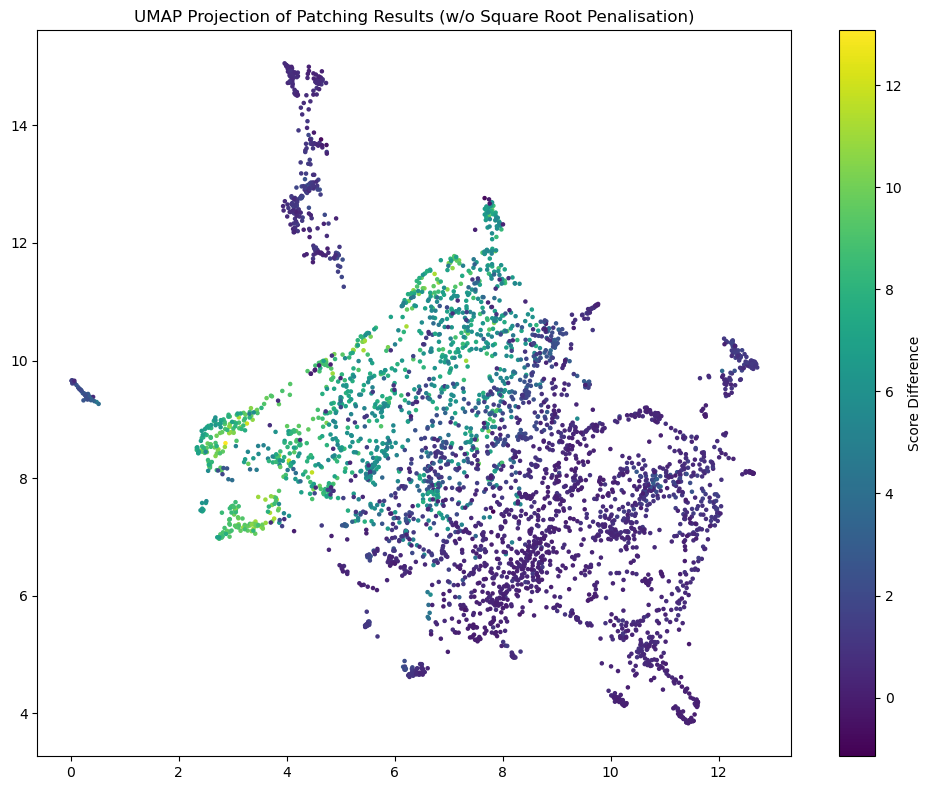

In [8]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

umap_embeddings = reducer.fit_transform(patching_results_normalised_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=score_difference, cmap='viridis', s=5)
plt.title('UMAP Projection of Patching Results (w/o Square Root Penalisation)')
plt.colorbar(label='Score Difference')
plt.tight_layout()
plt.show()

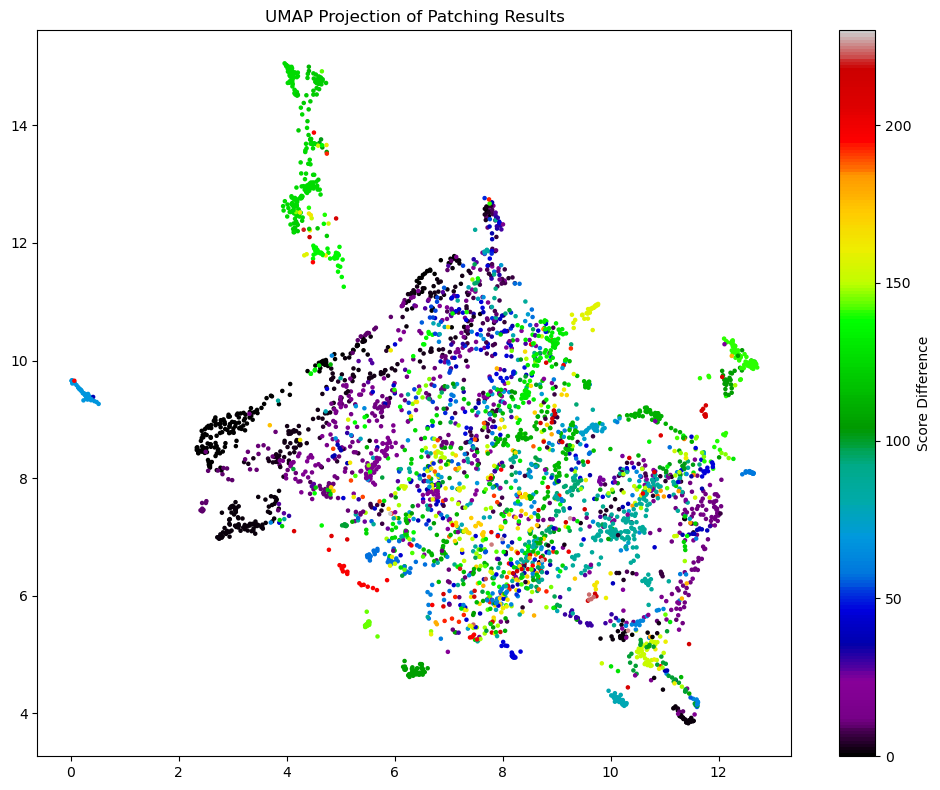

In [19]:
n_colors = len(unique_terms)
colors = plt.cm.nipy_spectral(np.linspace(0, 1, n_colors))
discrete_cmap = mcolors.ListedColormap(colors)

plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=all_data_pd['term_id'], cmap=discrete_cmap, s=5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Score Difference')
plt.tight_layout()
plt.show()

/scratch_local/esx208-1097358/ir_mech_interp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/scratch_local/esx208-1097358/ir_mech_interp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


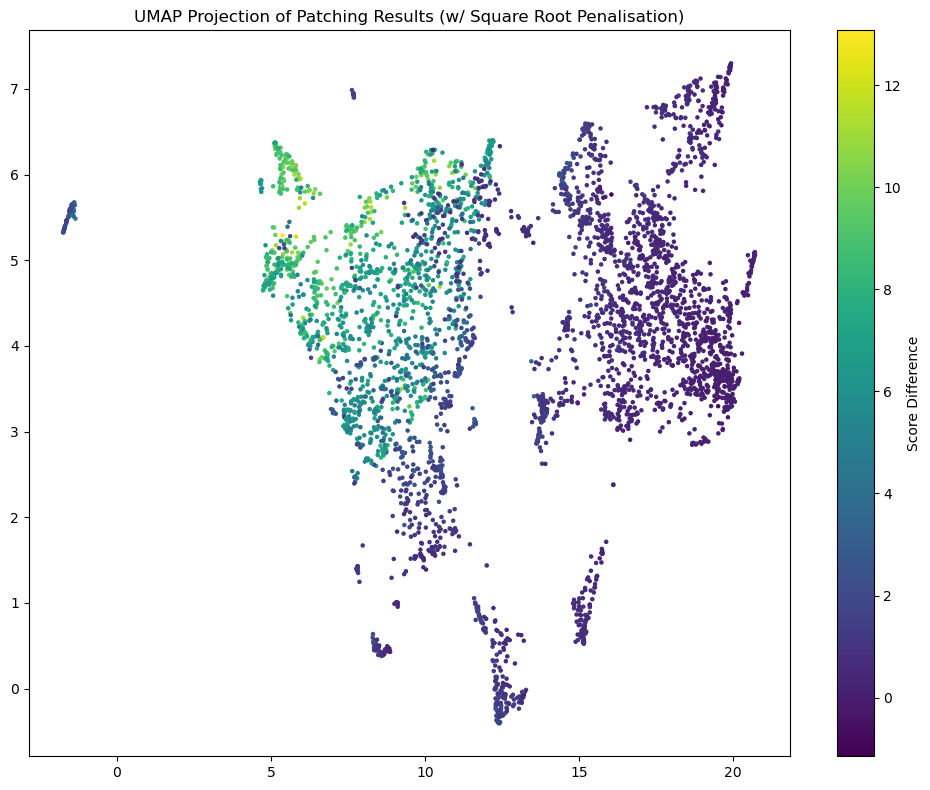

In [9]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

umap_embeddings_square = reducer.fit_transform(patching_results_normalised_vectors_square)

plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings_square[:, 0], umap_embeddings_square[:, 1], c=score_difference, cmap='viridis', s=5)
plt.title('UMAP Projection of Patching Results (w/ Square Root Penalisation)')
plt.colorbar(label='Score Difference')
plt.tight_layout()
plt.show()

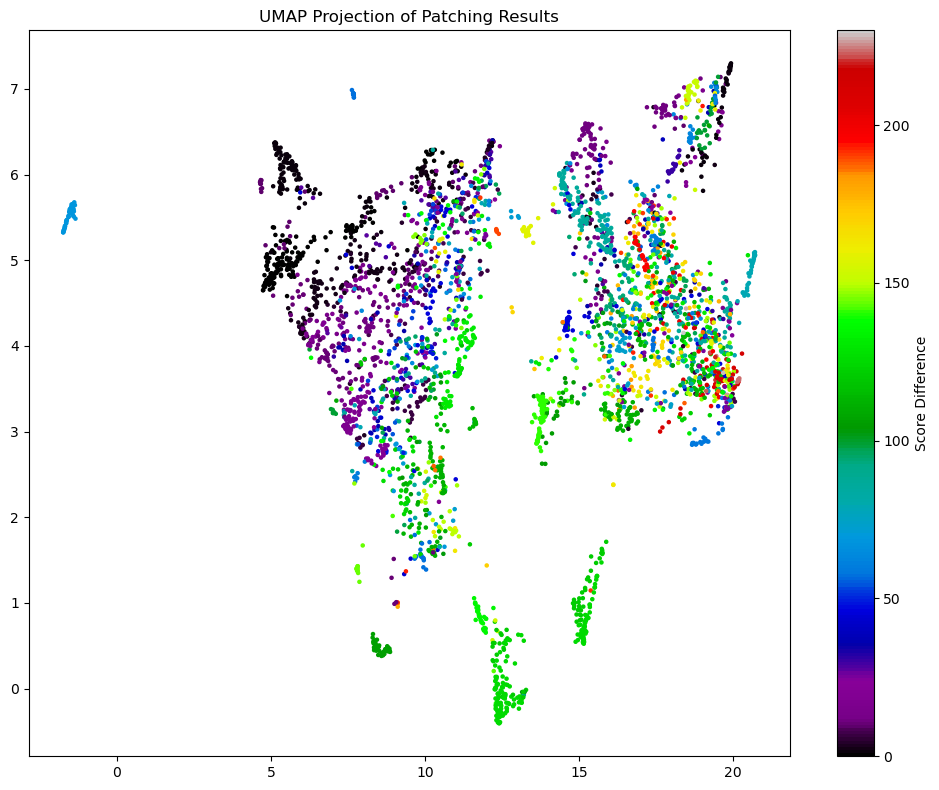

In [29]:
plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings_square[:, 0], umap_embeddings_square[:, 1], c=all_data_pd['term_id'], cmap=discrete_cmap_injected_terms, s=5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Score Difference')
plt.tight_layout()
plt.show()

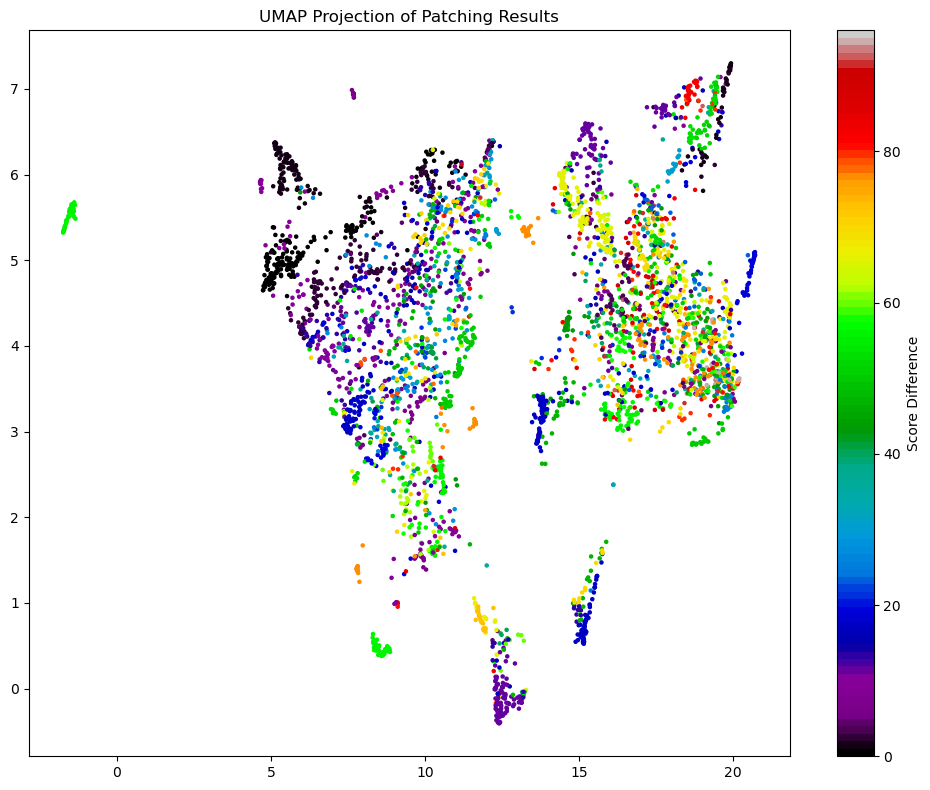

In [30]:
plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings_square[:, 0], umap_embeddings_square[:, 1], c=all_data_pd['qid_sequential'], cmap=discrete_cmap_queries, s=5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Score Difference')
plt.tight_layout()
plt.show()

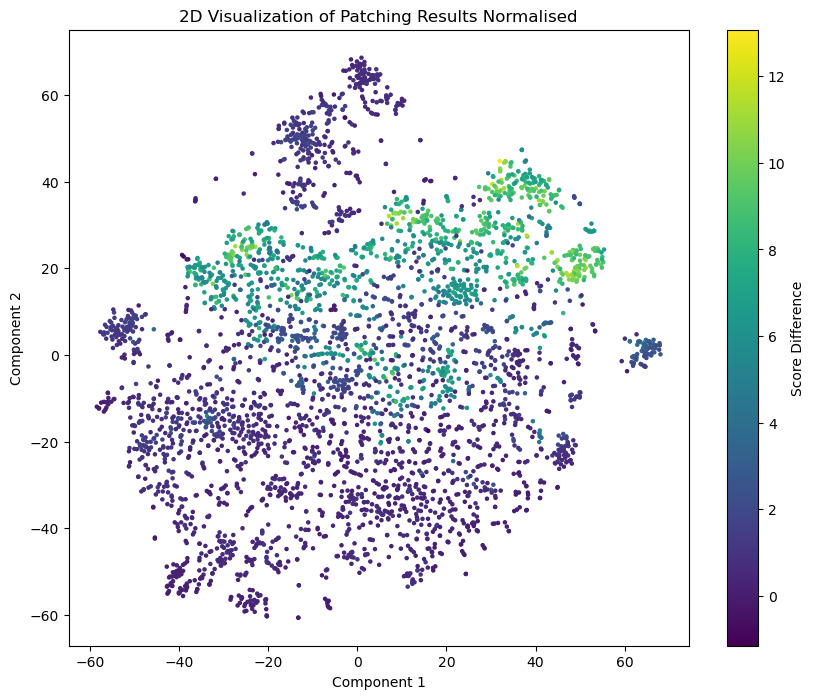

In [32]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_data = tsne.fit_transform(patching_results_normalised_vectors)


plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=score_difference, cmap='viridis', s=5)
plt.colorbar(label='Score Difference')
plt.title('2D Visualization of Patching Results Normalised')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

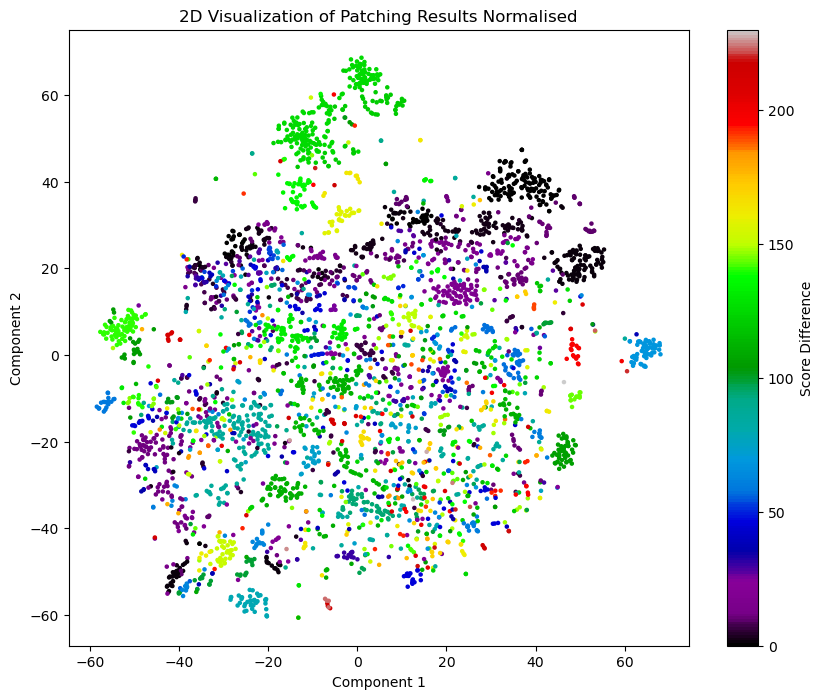

In [33]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=all_data_pd['term_id'], cmap=discrete_cmap_injected_terms, s=5)
plt.colorbar(label='Score Difference')
plt.title('2D Visualization of Patching Results Normalised')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

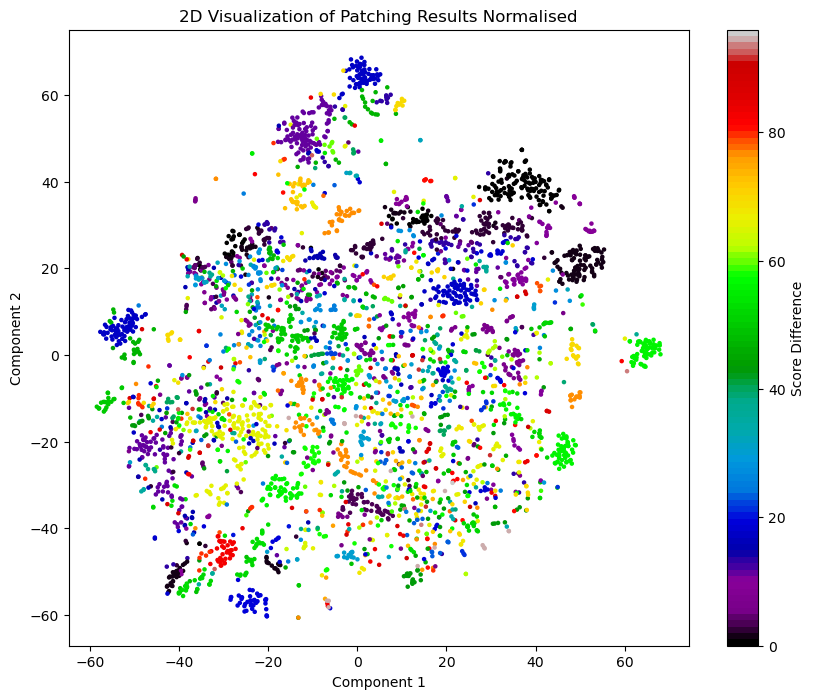

In [34]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=all_data_pd['qid_sequential'], cmap=discrete_cmap_queries, s=5)
plt.colorbar(label='Score Difference')
plt.title('2D Visualization of Patching Results Normalised')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

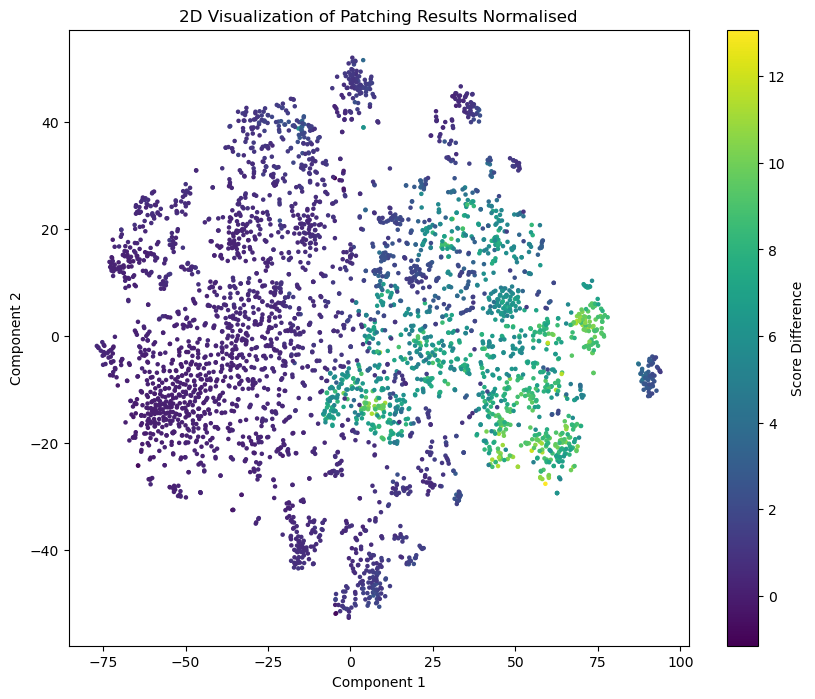

In [7]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_data_square = tsne.fit_transform(patching_results_normalised_vectors_square)


plt.figure(figsize=(10, 8))
plt.scatter(reduced_data_square[:, 0], reduced_data_square[:, 1], c=score_difference, cmap='viridis', s=5)
plt.colorbar(label='Score Difference')
plt.title('2D Visualization of Patching Results Normalised')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

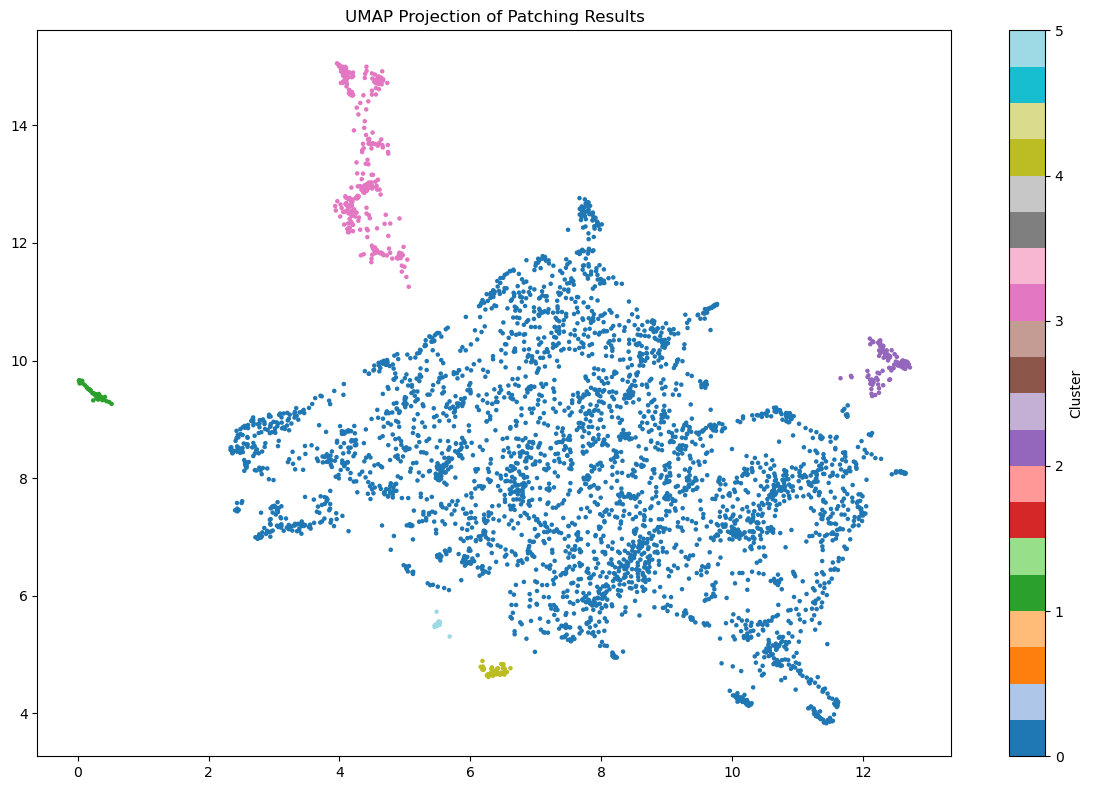

In [14]:
eps=0.4
dbscan = DBSCAN(eps=eps, min_samples=5)
cluster_labels_umap = dbscan.fit_predict(umap_embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c = cluster_labels_umap, cmap='tab20', s=5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

In [17]:
all_data_pd[cluster_labels_umap == 1].injected_term.value_counts()

injected_term
volunterilay    56
fao              1
russia           1
Name: count, dtype: int64

In [18]:
all_data_pd[cluster_labels_umap == 2].injected_term.value_counts()

injected_term
medical     70
laws        25
produces     1
margin       1
synaptic     1
's           1
flea         1
Name: count, dtype: int64

In [16]:
all_data_pd[cluster_labels_umap == 3].injected_term.value_counts()

injected_term
define         177
definition      55
difference      38
who              5
meaning          3
key              2
produces         2
laws             2
mean             2
low              2
made             1
remove           1
's               1
ventilation      1
cycle            1
causes           1
killed           1
mechanical       1
day              1
types            1
terminals        1
average          1
Name: count, dtype: int64

In [19]:
all_data_pd[cluster_labels_umap == 4].injected_term.value_counts()

injected_term
ww1    50
Name: count, dtype: int64

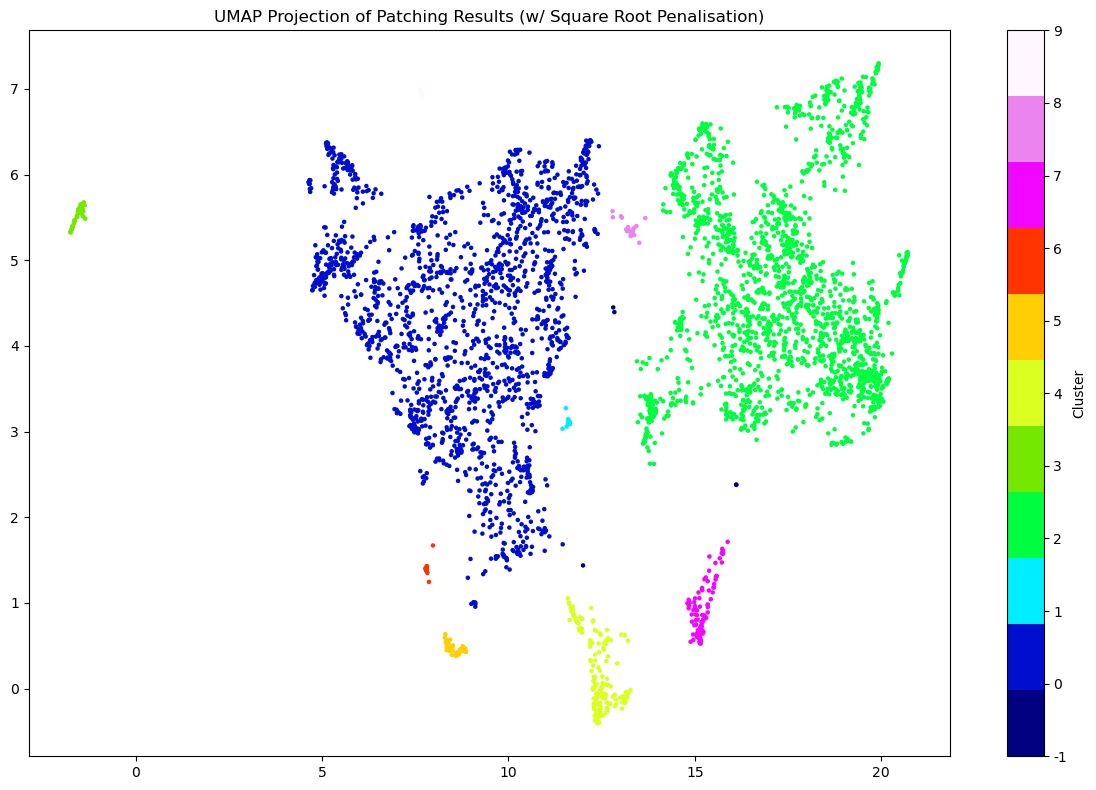

In [14]:
eps=0.4
dbscan = DBSCAN(eps=eps, min_samples=5)
cluster_labels_umap_square = dbscan.fit_predict(umap_embeddings_square)

unique_clusters = np.unique(cluster_labels_umap_square)
n_clusters = len(unique_clusters)

colors = plt.cm.gist_ncar(np.linspace(0, 1, n_clusters))
discrete_cmap = mcolors.ListedColormap(colors)

plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings_square[:, 0], umap_embeddings_square[:, 1], c = cluster_labels_umap_square, cmap=discrete_cmap, s=5)

cbar = plt.colorbar(ticks=range(-1, n_clusters-1))
cbar.set_label('Cluster')
cbar.set_ticklabels(range(-1, n_clusters-1))

plt.title('UMAP Projection of Patching Results (w/ Square Root Penalisation)')
plt.tight_layout()
plt.show()

In [15]:
cluster_id = 2
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap_square == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap_square == cluster_id]['injected_term'].value_counts())

Cluster ID: 2
##########
query
exons definition biology                                                  193
define etruscans                                                           90
what is a active margin                                                    81
define bmt medical                                                         76
does legionella pneumophila cause pneumonia                                70
                                                                         ... 
average salary for dental hygienist in nebraska                             2
how often to button quail lay eggs                                          1
what are the three percenters?                                              1
what type of conflict does della face in o, henry the gift of the magi      1
how many sons robert kraft has                                              1
Name: count, Length: 94, dtype: int64
##########
injected_term
exons        191
etruscans     89
medical       

In [17]:
cluster_id = 4
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap_square == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap_square == cluster_id]['injected_term'].value_counts())

Cluster ID: 4
##########
query
define etruscans                                           102
difference between rn and bsn                               24
definition of a sigmet                                       8
difference between a mcdouble and a double cheeseburger      8
rsa definition key                                           6
exons definition biology                                     6
define pareto chart in statistics                            6
what amino produces carnitine                                3
define bmt medical                                           3
define visceral?                                             3
lps laws definition                                          3
meaning of shebang                                           2
who killed nicholas ii of russia                             1
definition declaratory judgment                              1
anthropological definition of environment                    1
Name: count, dtype: int6

In [18]:
cluster_id = 5
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap_square == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap_square == cluster_id]['injected_term'].value_counts())

Cluster ID: 5
##########
query
why did the us volunterilay enter ww1    50
Name: count, dtype: int64
##########
injected_term
ww1    50
Name: count, dtype: int64


In [19]:
cluster_id = 6
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap_square == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap_square == cluster_id]['injected_term'].value_counts())

Cluster ID: 6
##########
query
what does it mean if your tsh is low    15
Name: count, dtype: int64
##########
injected_term
tsh    15
Name: count, dtype: int64


In [20]:
cluster_id = 7
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap_square == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap_square == cluster_id]['injected_term'].value_counts())

Cluster ID: 7
##########
query
define bmt medical                                 61
lps laws definition                                15
medicare's definition of mechanical ventilation    11
definition of a sigmet                             10
how long is life cycle of flea                      1
Name: count, dtype: int64
##########
injected_term
define        61
definition    36
long           1
Name: count, dtype: int64


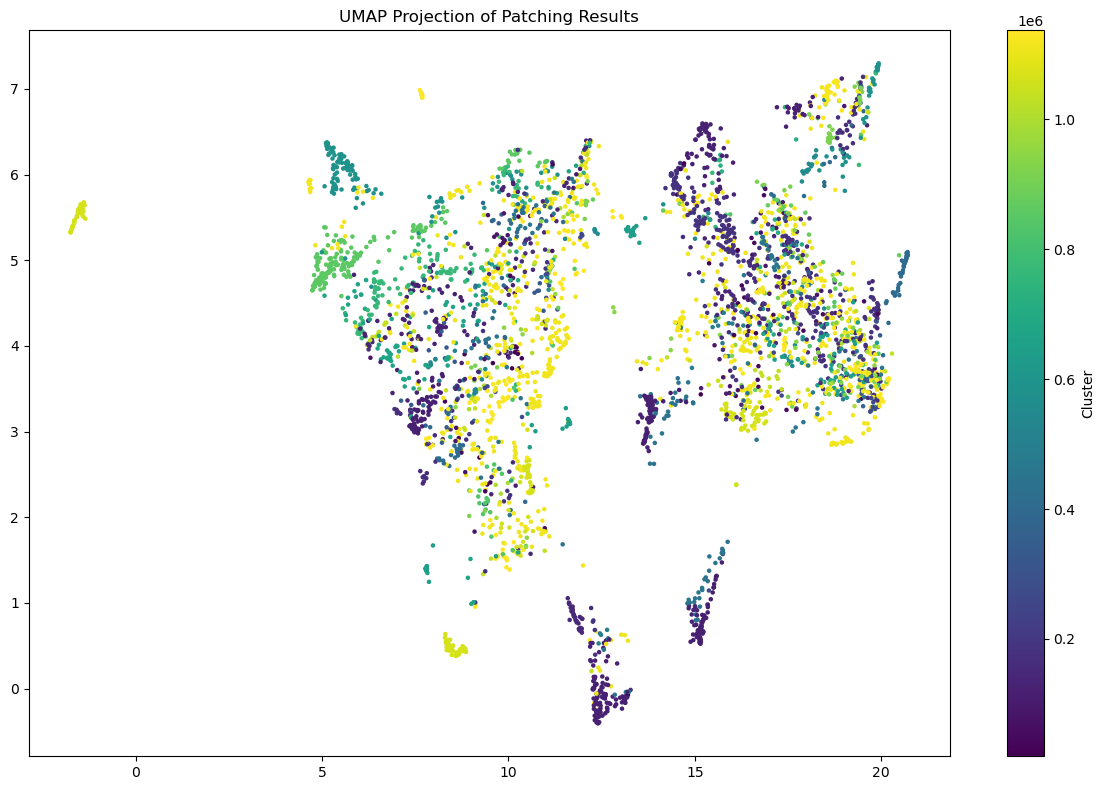

In [37]:
eps=0.4
dbscan = DBSCAN(eps=eps, min_samples=5)
cluster_labels_umap_square = dbscan.fit_predict(umap_embeddings_square)

plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings_square[:, 0], umap_embeddings_square[:, 1], c = all_data_pd['qid'].values, cmap='viridis', s=5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

In [24]:
all_data_pd[cluster_labels_umap_square == 0].injected_term.value_counts()

injected_term
theraderm     176
carvedilol    135
mamey         124
alm            97
bmt            74
             ... 
reduce          1
type            1
conflict        1
hydrogen        1
tsh             1
Name: count, Length: 168, dtype: int64

In [32]:
all_data_pd[cluster_labels_umap_square == 1].injected_term.value_counts()

injected_term
low      16
white     1
Name: count, dtype: int64

In [26]:
all_data_pd[cluster_labels_umap_square == 2].injected_term.value_counts()

injected_term
exons        191
etruscans     89
medical       76
low           50
active        49
            ... 
redgrave       1
public         1
old            1
cerebral       1
net            1
Name: count, Length: 192, dtype: int64

In [29]:
all_data_pd[cluster_labels_umap_square == 3].injected_term.value_counts()

injected_term
volunterilay    56
Name: count, dtype: int64

In [30]:
all_data_pd[cluster_labels_umap_square == 4].injected_term.value_counts()

injected_term
define             114
difference          32
definition          21
produces             3
key                  2
meaning              2
killed               1
anthropological      1
biology              1
Name: count, dtype: int64

In [31]:
all_data_pd[cluster_labels_umap_square == 5].injected_term.value_counts()

injected_term
ww1    50
Name: count, dtype: int64

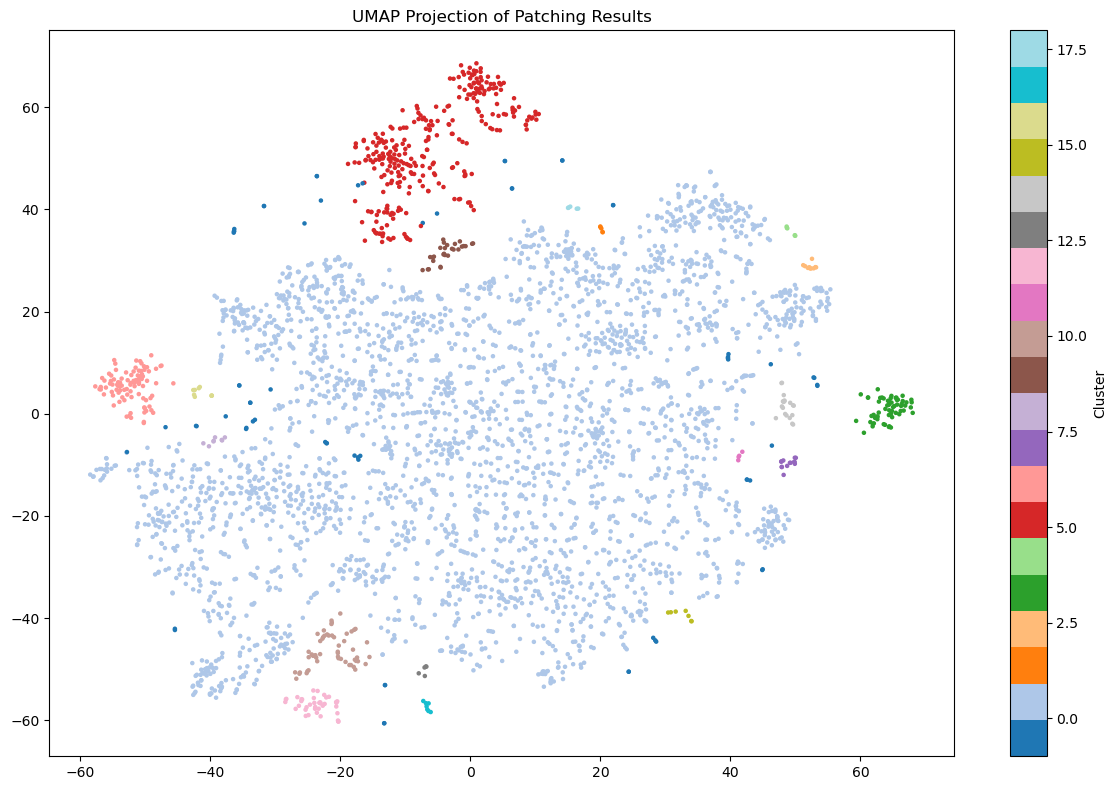

In [39]:
eps=3
dbscan = DBSCAN(eps=eps, min_samples=5)
cluster_labels_tsne = dbscan.fit_predict(reduced_data)

plt.figure(figsize=(12, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c = cluster_labels_tsne, cmap='tab20', s=5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c = cluster_labels_tsne, cmap='tab20', s=5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

In [42]:
all_data_pd[cluster_labels_tsne == 5]

,qid,query,docno,text,relevance,perturbed,perturbed_score,rank,original_score,score_delta,perturbed_text,injected_term,term_id,qid_sequential
1215,131843,definition of a sigmet,8710814,Customers who equip their helicopter with the ...,1,True,-3.098753,50,-5.750914,2.652161,Customers who equip their helicopter with the ...,definition,121,13
1226,121171,define etruscans,5237906,"Our Etruscan Mystery tour begins in Tarquinia,...",1,True,-2.615835,211,-5.126186,2.510352,"Our Etruscan Mystery tour begins in Tarquinia,...",define,125,11
1241,121171,define etruscans,6580477,The Tomb paintings also suggest; that sometime...,1,True,-2.821998,231,-5.210130,2.388132,The Tomb paintings also suggest; that sometime...,define,125,11
1255,121171,define etruscans,2156101,The area of modern Piombino was settled since ...,1,True,-2.079893,161,-4.350245,2.270353,The area of modern Piombino was settled since ...,define,125,11
1263,121171,define etruscans,1331148,During this period the Celts waged three great...,1,True,-1.959216,151,-4.171990,2.212773,During this period the Celts waged three great...,define,125,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559,451602,medicare's definition of mechanical ventilation,1211647,Types of CPAP Masks and BiPAP Masks. Sleep apn...,3,True,-10.760522,402,-10.921006,0.160484,Types of CPAP Masks and BiPAP Masks. Sleep apn...,definition,121,70
3755,264014,how long is life cycle of flea,3396076,"There are four stages in a flea's life: egg, l...",3,True,3.807723,9,3.739599,0.068124,"There are four stages in a flea's life: egg, l...",cycle,195,25
3776,451602,medicare's definition of mechanical ventilation,8390518,Mechanical ventilation is the medical term for...,3,True,-0.803556,0,-0.863487,0.059931,Mechanical ventilation is the medical term for...,ventilation,197,70
3792,258062,how long does it take to remove wisdom tooth,955813,The procedure will take about 30 to 60 minutes...,3,True,4.147544,6,4.092629,0.054916,The procedure will take about 30 to 60 minutes...,remove,220,39


In [44]:
all_data_pd[cluster_labels_tsne == 5]['injected_term'].value_counts()

injected_term
define         177
definition      55
difference      39
who              8
key              2
laws             2
meaning          2
amino            1
remove           1
ventilation      1
cycle            1
types            1
mechanical       1
causes           1
day              1
produces         1
average          1
Name: count, dtype: int64

In [45]:
all_data_pd[cluster_labels_tsne == 6]

,qid,query,docno,text,relevance,perturbed,perturbed_score,rank,original_score,score_delta,perturbed_text,injected_term,term_id,qid_sequential
1163,443396,lps laws definition,457791,involuntary - not subject to the control of th...,1,True,-6.462769,175,-9.852500,3.389731,involuntary - not subject to the control of th...,laws,105,47
1307,443396,lps laws definition,7305588,Facilities that are recognized by the Departme...,1,True,-7.899036,205,-9.760911,1.861875,Facilities that are recognized by the Departme...,laws,105,47
1323,118440,define bmt medical,2607757,† The patient’s bone marrow then is replaced w...,1,True,-7.654923,281,-9.405401,1.750478,† The patient’s bone marrow then is replaced w...,medical,141,17
1345,118440,define bmt medical,8041325,Treatment with high-dose chemotherapy destroys...,1,True,-6.822195,233,-8.498471,1.676276,Treatment with high-dose chemotherapy destroys...,medical,141,17
1358,118440,define bmt medical,5475294,A stem cell transplant (also called hematopoie...,1,True,-6.736402,228,-8.360679,1.624277,A stem cell transplant (also called hematopoie...,medical,141,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3187,118440,define bmt medical,224513,a bone marrow or cord blood transplant is a pr...,3,True,-6.819812,232,-7.727031,0.907219,a bone marrow or cord blood transplant is a pr...,medical,141,17
3466,118440,define bmt medical,7092476,A bone marrow transplant is a medical procedur...,3,True,-6.352790,218,-6.584813,0.232023,A bone marrow transplant is a medical procedur...,medical,141,17
3586,443396,lps laws definition,6555774,The Baker Act is a creation of Florida law and...,3,True,-9.467817,292,-9.613606,0.145788,The Baker Act is a creation of Florida law and...,laws,105,47
3617,118440,define bmt medical,3038505,A bone marrow transplant is a medical procedur...,3,True,-5.524566,191,-5.653922,0.129356,A bone marrow transplant is a medical procedur...,medical,141,17


In [46]:
all_data_pd[cluster_labels_tsne == 6]['injected_term'].value_counts()

injected_term
medical     67
laws        23
margin       1
synaptic     1
flea         1
Name: count, dtype: int64

In [ ]:
|